# SSVGP demo on Toy example from paper

In [1]:
"""
Importing general library requirements
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time # just for measuring runtime

""" 
SS GP algorithm functions
"""
import os
os.chdir('C:/Users/hughw/Documents/MSC project/GP algorithms/Master function files')
from SSVGP import kernel_funcs
from SSVGP import model_funcs
from SSVGP import draw_simulation
from SSVGP import train
from SSVGP import evaluation
from SSVGP import test
from SSVGP import diagnostics
from SS_GP_PMF import train as train_pmf
from functools import partial
os.chdir('C:/Users/hughw/Documents/MSC project/Simulation results')

In [2]:
"""
Imports for GPytorch
"""

import math
import torch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2

def GPR(training_iter=100, lr=0.1,ls_init=1):
    
    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=p))
            self.covar_module.base_kernel.lengthscale *= ls_init

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    losses = np.zeros(0)
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        losses = np.append(losses,loss.item())
        optimizer.step()
    
    return(model,likelihood,losses)

## Run ML-II GP on a synthetic dataset

In [71]:
"""
# Draw dataset from toy example in paper
"""
n=300
ntrain=n
ntest=100
p=100
q=10

np.random.seed(0)

Y,X,f = draw_simulation.toy_example(n,p,q,noise=0.05)

Xtrain = (X[:n]-X[:n].mean(0))/X[:n].var(0)**0.5
Xtest = (X[n:]-X[:n].mean(0))/X[:n].var(0)**0.5
ytrain = (Y[:n]-Y[:n].mean())/Y[:n].var()**0.5
ytest = (Y[n:]-Y[:n].mean())/Y[:n].var()**0.5

MSE = np.zeros(3)
runtime = np.zeros(3)

In [72]:
"""
ML-II GP
"""

# Passing data into torch
train_x = torch.from_numpy(Xtrain).float()
train_y = torch.from_numpy(ytrain.reshape(n,)).float()

# Training
t = time.time()
model,likelihood,losses = GPR(training_iter=2000, lr=0.1,ls_init=np.sqrt(p))

# Testing
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.from_numpy(Xtest).float()
    observed_pred = likelihood(model(test_x))

# storing
runtime[0] = time.time()-t
MSE[0] = diagnostics.MSE_pc(observed_pred.mean.numpy().reshape(ntest,1), ytest.reshape(ntest,1))
print("MSE is : ", MSE[0])
print("Runtime is : ", runtime[0])
inv_lengthscales = 1/model.covar_module.base_kernel.lengthscale.detach().numpy()[0]

MSE is :  0.12484934181753168
Runtime is :  10.546730756759644


##  Inverse lengthscale profile plot for ML-II GP makes it difficult to determine appropriate variable selection threshold

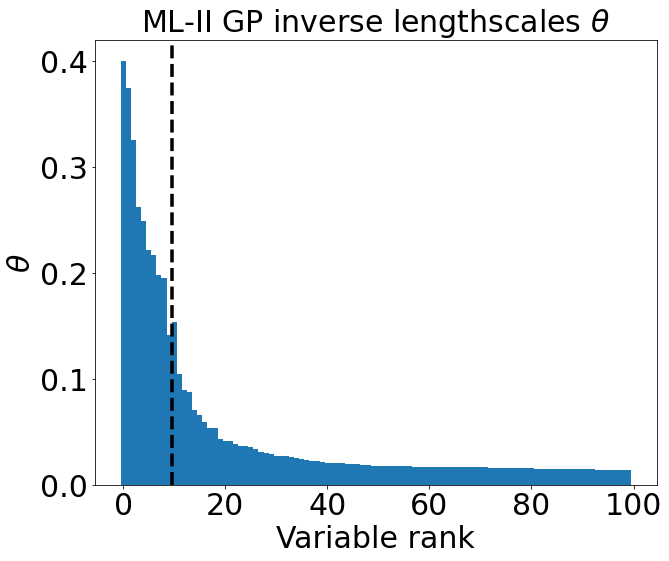

In [73]:
"""
Plotting inverse lengthscales ordered by size
"""
plt.rc('axes',edgecolor='black')
font ={'size'   : 30}
plt.rc('font', **font)

d=100
sorted_ILS = np.concatenate((np.sort(inv_lengthscales[:q])[::-1],np.sort(inv_lengthscales[q:])[::-1]))



plt.rcParams.update({'text.color' : "black",
                      'xtick.color' : "black",
                      'ytick.color' : "black",
                     'axes.labelcolor' : "black"})
fig,axs = plt.subplots(figsize=(10,8.5))
fig.set_facecolor('white')
axs.set_facecolor('white')
axs.set_xlabel("Variable rank")
axs.set_ylabel(r"$\theta$")
axs.set_title(r"ML-II GP inverse lengthscales $\theta$",fontsize=30)
plt.bar(range(d),height = sorted_ILS[:d], width = 0.65+(p>10)*0.35)
plt.axvline(x=q-0.5, color = "black", linestyle = "--", lw = 3.5)
plt.tight_layout()

## Running SSVGP

In [81]:
# Training
t = time.time()
np.random.seed(0)
linit,sinit,siginit,logl,L,opt_sums = train.kernel_param_optimise(ytrain.reshape(ntrain,1),Xtrain, l0=1/np.sqrt(p),s0=1,sig0=1,minibatch=n/2,c=1e-8,v=1e+7,learn_rate=0.01)
Results,Selections = train.model(ytrain,Xtrain, training_args = ["l0", "s0", "sig0", "seed", "minibatch", "init_grad_step", "aCAVI_iter", "learn_rate", "optimisation_sums"], 
                                 training_arg_vals = [linit,sinit,siginit,0, n/2, 0, 5, 0.05, opt_sums])

# Evaluation (LOO-LPD computation)
loo_lpd,pip,mu,weights,Ymean1,Yvar1 = evaluation.model(ytrain,Xtrain,Results, reg_var = 1, NN=n)

# Testing
testing_algorithm = partial(test.posterior_predictive)
fmean,ymean = test.model(ytrain,Xtrain,Xtest,testing_algorithm,Results,weights,MC_samples=100)

runtime[2] = time.time()-t
MSE[2] =  diagnostics.MSE_pc(ymean.reshape(ntest,1),ytest.reshape(ntest,1))
print("MSE is : ", MSE[2])
print("Runtime is : ", runtime[2])

LOO-LPD 1 is : -37.76342235186462
LOO-LPD 2 is : -38.346304854461394
LOO-LPD 3 is : -36.6707750917303
LOO-LPD 4 is : -35.60103526963363
LOO-LPD 5 is : -35.77376586295601
LOO-LPD 6 is : -33.86428349755738
LOO-LPD 7 is : -40.46982579093567
LOO-LPD 8 is : -96.26391433351404
LOO-LPD 9 is : -1096.263914333514
LOO-LPD 10 is : -2096.263914333514
LOO-LPD 11 is : -3096.263914333514
MSE is :  0.09998533058790322
Runtime is :  16.612730026245117


## SSVGP regularises inverse lengthscale posterior and excludes irrelevant variables with high probability

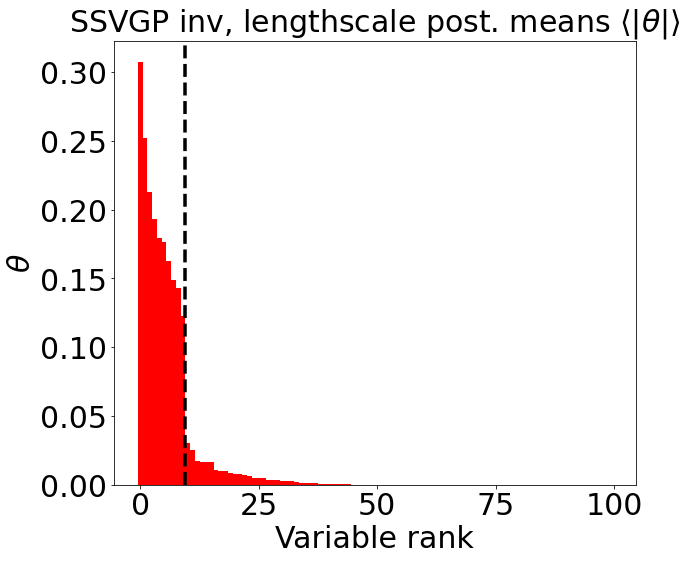

In [82]:
"""
Plotting inverse lengthscale post.means ordered by size
"""
plt.rc('axes',edgecolor='black')
font ={'size'   : 30}
plt.rc('font', **font)
d=100 
sorted_ILS = np.concatenate((np.sort(mu[:q])[::-1],np.sort(mu[q:])[::-1]))

plt.rcParams.update({'text.color' : "black",
                      'xtick.color' : "black",
                      'ytick.color' : "black",
                     'axes.labelcolor' : "black"})
fig,axs = plt.subplots(figsize=(10,8.5))
fig.set_facecolor('white')
axs.set_facecolor('white')
axs.set_xlabel("Variable rank")
axs.set_ylabel(r"$\theta$")
axs.set_title(r"SSVGP inv, lengthscale post. means $\langle| \theta |\rangle $",fontsize=30)
plt.bar(range(d),height = sorted_ILS[:d], width = 0.65+(p>10)*0.35, color = "red")
plt.axvline(x=q-0.5, color = "black", linestyle = "--", lw = 3.5)
plt.tight_layout()

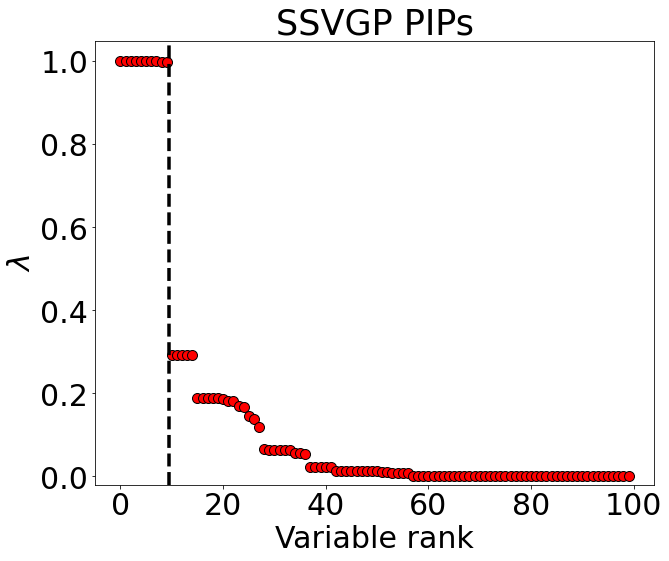

In [83]:
"""
Plotting PIPs ordered by size
"""
plt.rc('axes',edgecolor='black')
font ={'size'   : 30}
plt.rc('font', **font)

sorted_PIPs = np.concatenate((np.sort(pip[:q])[::-1],np.sort(pip[q:])[::-1]))

fig,axs = plt.subplots(figsize=(10,8.5))
plt.xlabel("Variable rank")
plt.ylabel(r"$\lambda$")
axs.set_title(r"SSVGP PIPs", fontsize=35)

plt.scatter(range(d),sorted_PIPs[:d], color = "red", s=100, marker = "o", edgecolors="black")
plt.ylim(-0.02,1.05)
plt.axvline(x=q-0.5, linestyle = "--", color = "black", label = "LHS: true inclusions"+"\n"+"RHS: true exclusions", lw = 3.5)
plt.tight_layout()
plt.show()

## Running Dirac spike and slab GP with PMF and BBVI (scoregrad)

In [9]:
t = time.time()
results_PMF = train_pmf.GP_SS_PMF(ytrain,Xtrain, sd0=1e-3, v1=0.1, logpi=np.log(0.05), log1_pi = np.log(0.95), svi_sample_score=10)

Ymean=0
for i in range(100):
    l=np.random.normal(results_PMF[0],results_PMF[1],p)*(np.random.random(p)<=results_PMF[4])
    fm,fv,ym,yv = test.posterior_predictive(ytrain,Xtrain,Xtest,l = l, s=results_PMF[2],sig=results_PMF[3], latents = False)
    Ymean += ym/100
    
runtime[1] = time.time()-t
MSE[1] =  diagnostics.MSE_pc(Ymean[None,:],ytest[None,:])
print("MSE is : ", MSE[1])
print("Runtime is : ", runtime[1])

MSE is :  0.09354328994933604
Runtime is :  41.8712112903595


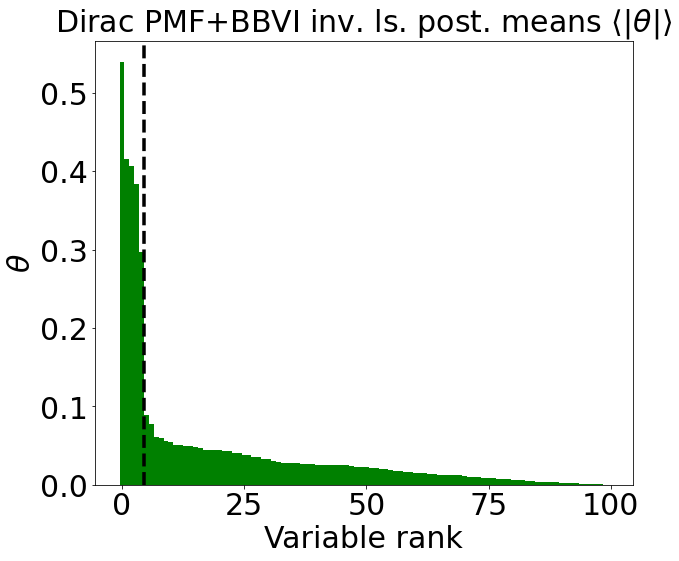

In [10]:
"""
Plotting inverse lengthscale post.means ordered by size
"""
plt.rc('axes',edgecolor='black')
font ={'size'   : 30}
plt.rc('font', **font)

sorted_ILS = np.concatenate((np.sort(np.abs(results_PMF[0]*results_PMF[4])[:q])[::-1],np.sort(np.abs(results_PMF[0]*results_PMF[4])[q:])[::-1]))

plt.rcParams.update({'text.color' : "black",
                      'xtick.color' : "black",
                      'ytick.color' : "black",
                     'axes.labelcolor' : "black"})
fig,axs = plt.subplots(figsize=(10,8.5))
fig.set_facecolor('white')
axs.set_facecolor('white')
axs.set_xlabel("Variable rank")
axs.set_ylabel(r"$\theta$")
axs.set_title(r"Dirac PMF+BBVI inv. ls. post. means $\langle| \theta |\rangle $",fontsize=30)
plt.bar(range(p),height = sorted_ILS, width = 0.65+(p>10)*0.35, color = "green")
plt.axvline(x=q-0.5, color = "black", linestyle = "--", lw = 3.5)
plt.tight_layout()

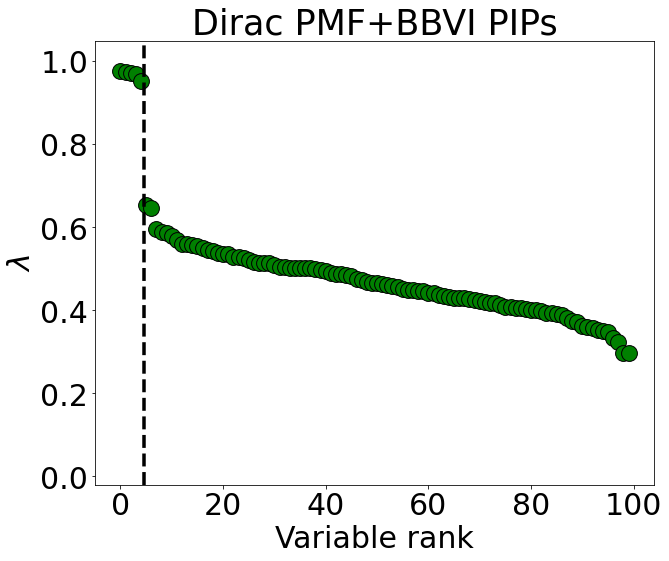

In [11]:
"""
Plotting PIPs ordered by size
"""
plt.rc('axes',edgecolor='black')
font ={'size'   : 30}
plt.rc('font', **font)

sorted_PIPs = np.concatenate((np.sort(results_PMF[4][:q])[::-1],np.sort(results_PMF[4][q:])[::-1]))


fig,axs = plt.subplots(figsize=(10,8.5))
plt.xlabel("Variable rank")
plt.ylabel(r"$\lambda$")
axs.set_title(r"Dirac PMF+BBVI PIPs", fontsize=35)

plt.scatter(range(p),sorted_PIPs, color = "green", s=250, marker = "o", edgecolors="black")
plt.ylim(-0.02,1.05)
plt.axvline(x=q-0.5, linestyle = "--", color = "black", label = "LHS: true inclusions"+"\n"+"RHS: true exclusions", lw = 3.5)
plt.tight_layout()
plt.show()

In [12]:
"""
Performance comparison
"""
print("ML-II MSE : ", MSE[0])
print("PMF+BBVI MSE : ", MSE[1])
print("SSVGP MSE : ", MSE[2])

print("ML-II runtime : ", runtime[0])
print("PMF+BBVI runtime : ", runtime[1])
print("SSVGP runtime : ", runtime[2])

ML-II MSE :  0.0952954609298492
PMF+BBVI MSE :  0.09354328994933604
SSVGP MSE :  0.062457745479311634
ML-II runtime :  10.474506855010986
PMF+BBVI runtime :  41.8712112903595
SSVGP runtime :  13.260931253433228
